# Оптимизация с помощью `scipy.optimize`

**Двумерные функции**


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Целевые-функции" data-toc-modified-id="Целевые-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Целевые функции</a></span><ul class="toc-item"><li><span><a href="#Квадратичная-функция" data-toc-modified-id="Квадратичная-функция-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Квадратичная функция</a></span></li><li><span><a href="#Функция-Розенброка" data-toc-modified-id="Функция-Розенброка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функция Розенброка</a></span></li><li><span><a href="#Bean-function" data-toc-modified-id="Bean-function-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Bean function</a></span></li><li><span><a href="#Функция-Джонса" data-toc-modified-id="Функция-Джонса-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Функция Джонса</a></span></li><li><span><a href="#Две-пружинки" data-toc-modified-id="Две-пружинки-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Две пружинки</a></span></li></ul></li><li><span><a href="#Безуслованая-оптимизация" data-toc-modified-id="Безуслованая-оптимизация-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Безуслованая оптимизация</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Метод-сопряжённых-градиентов" data-toc-modified-id="Метод-сопряжённых-градиентов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Метод сопряжённых градиентов</a></span></li><li><span><a href="#Метод-Бройдена-—-Флетчера-—-Гольдфарба-—-Шанно-(BFGS)" data-toc-modified-id="Метод-Бройдена-—-Флетчера-—-Гольдфарба-—-Шанно-(BFGS)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Метод Бройдена — Флетчера — Гольдфарба — Шанно (BFGS)</a></span></li><li><span><a href="#Метод-Нелдера-—-Мида-(симплекс)" data-toc-modified-id="Метод-Нелдера-—-Мида-(симплекс)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Метод Нелдера — Мида (симплекс)</a></span></li></ul></li><li><span><a href="#Услованая-оптимизация" data-toc-modified-id="Услованая-оптимизация-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Услованая оптимизация</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Метод-COBYLA" data-toc-modified-id="Метод-COBYLA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Метод COBYLA</a></span></li><li><span><a href="#Метод-SLSQP" data-toc-modified-id="Метод-SLSQP-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Метод SLSQP</a></span></li></ul></li></ul></div>

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy.optimize import minimize

In [3]:
# Styles
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
cm = plt.cm.tab10  # Colormap

# import seaborn
# seaborn.set_style('whitegrid')
from IPython.display import Image
im_width = 800

In [4]:
# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

## Целевые функции

Подключаем библиотеки, создаём вспомогательные функции.

In [5]:
from copy import deepcopy
def counted(f):
    def wrapped(*args, **kwargs):
        wrapped.calls += 1
        wrapped.Xk.append(deepcopy(*args))
#         print(wrapped.calls, *args)
        return f(*args, **kwargs)
    wrapped.calls = 0
    wrapped.Xk = []
    return wrapped

# auxiliary function to save intermediate points
def store(xk):
    Xk.append(xk)

### Квадратичная функция

$$ f(x_1, x_2) = x_1^2 + x_2^2 - \beta x_1 x_2, \quad \beta \in [0, 2) $$

Функция представляет собой наклонённую двумерную квадратичную функцию.
Сечения $z = const$ являются эллипсами.
Параметр $\beta$ отвечает за наклон и вытянутость эллипсов.
Если $\beta = 0$, то эллиптические контуры становятся круговыми.
При $\beta = 2$ эллипсы вырождаются в прямые, а линия $y = x$ является слабым минимумом.

In [6]:
@counted
def SQF(x):
    '''Slanted quadratic function, beta=[0,2)'''
    beta = 1.5
    return sum(x[:]**2) - beta*x[0]*x[1]
SQF.__name__ = 'SQF'

### Функция Розенброка

$$ f(x_1, x_2) = 100(x_2 - x_1^2)^2 + (1-x_1)^2 $$

Функция имеет единственный минимум, находящийся внутри узкой параболической долины в точке $x = (1, 1)$ и равный $0$.

Существует многомерное обобщение функции Розенброка:
$$
  f(\mathbf{x}) = \sum\limits_{i=1}^{N-1} \left[ 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2 \right].
$$

Глобальный минимум многомерной функции Розенброка также находится в точке $x_i = 1$ и тоже равен $0$.

Считается, что поиск глобального минимума данной функции является нетривиальной задачей, поэтому она часто используются для тестирования оптимизационных алгоритмов.

In [7]:
# definition of objective function and constraints
@counted
def rosen(x):
    '''Rosenbrock function'''
    # 2D: f = 100*(x2 - x1**2)**2 + (1 - x1)**2
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
rosen.__name__ = 'rosen'

# @counted
# def rosen_der(x):
#     xm = x[1:-1]
#     xm_m1 = x[:-2]
#     xm_p1 = x[2:]
#     der = np.zeros_like(x)
#     der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
#     der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
#     der[-1] = 200*(x[-1]-x[-2]**2)
#     return der

### Bean function

$$ f(x_1, x_2) = x_1^2 + x_2^2 + \beta x_1 x_2, \quad \beta \in [0, 2) $$

Данная функция является "смягчённой" версией функции Розенброка: в ней также присутствует долина, но значения производных гораздо меньше.

Минимум функции находится в точке $x = (1.21314, 0.82414)$ и равен $0.09194$.

In [8]:
# definition of objective function and constraints
@counted
def bean(x):
    '''Bean function'''
    return (1-x[0])**2 + (1-x[1])**2 + 0.5*(2*x[1]-x[0]**2)**2
bean.__name__ = 'bean'

### Функция Джонса

$$ f(x_1, x_2) = x_1^4 + x_2^4 - 4x_1^3 - 3x_2^3 + 2x_1^2 + 2x_1x_2 $$

Гладкая мультимодальная функция четвёртого порядка, хорошо подходящая для тестирования глобальных алгоритмов и метода мультистарт.

Глобальный минимум:\
$x = (2.6732, -0.6759)$, $f(x) = -13.5320$\
Локальные минимумы:\
$x = (-0.4495, 2.2928)$, $f(x) = -9.7770$\
$x = ( 2.4239, 1.9219)$, $f(x) = -9.0312$

In [9]:
# definition of objective function and constraints
@counted
def jones(x):
    '''Jones function'''
    return x[0]**4 + x[1]**4 - 4*x[0]**3 - 3*x[1]**3 + 2*x[0]**2 + 2*x[0]*x[1]
jones.__name__ = 'jones'

### Две пружинки

Груз массой $m$ закреплён на двух недеформированных пружинах $k_1, l_1$ и $k_2, l_2$ (см. рисунок). Найти положение равновесия системы для $k_1=1$, $l_1=12$, $k_2=9$, $l_2=7$, $m=0.7$.

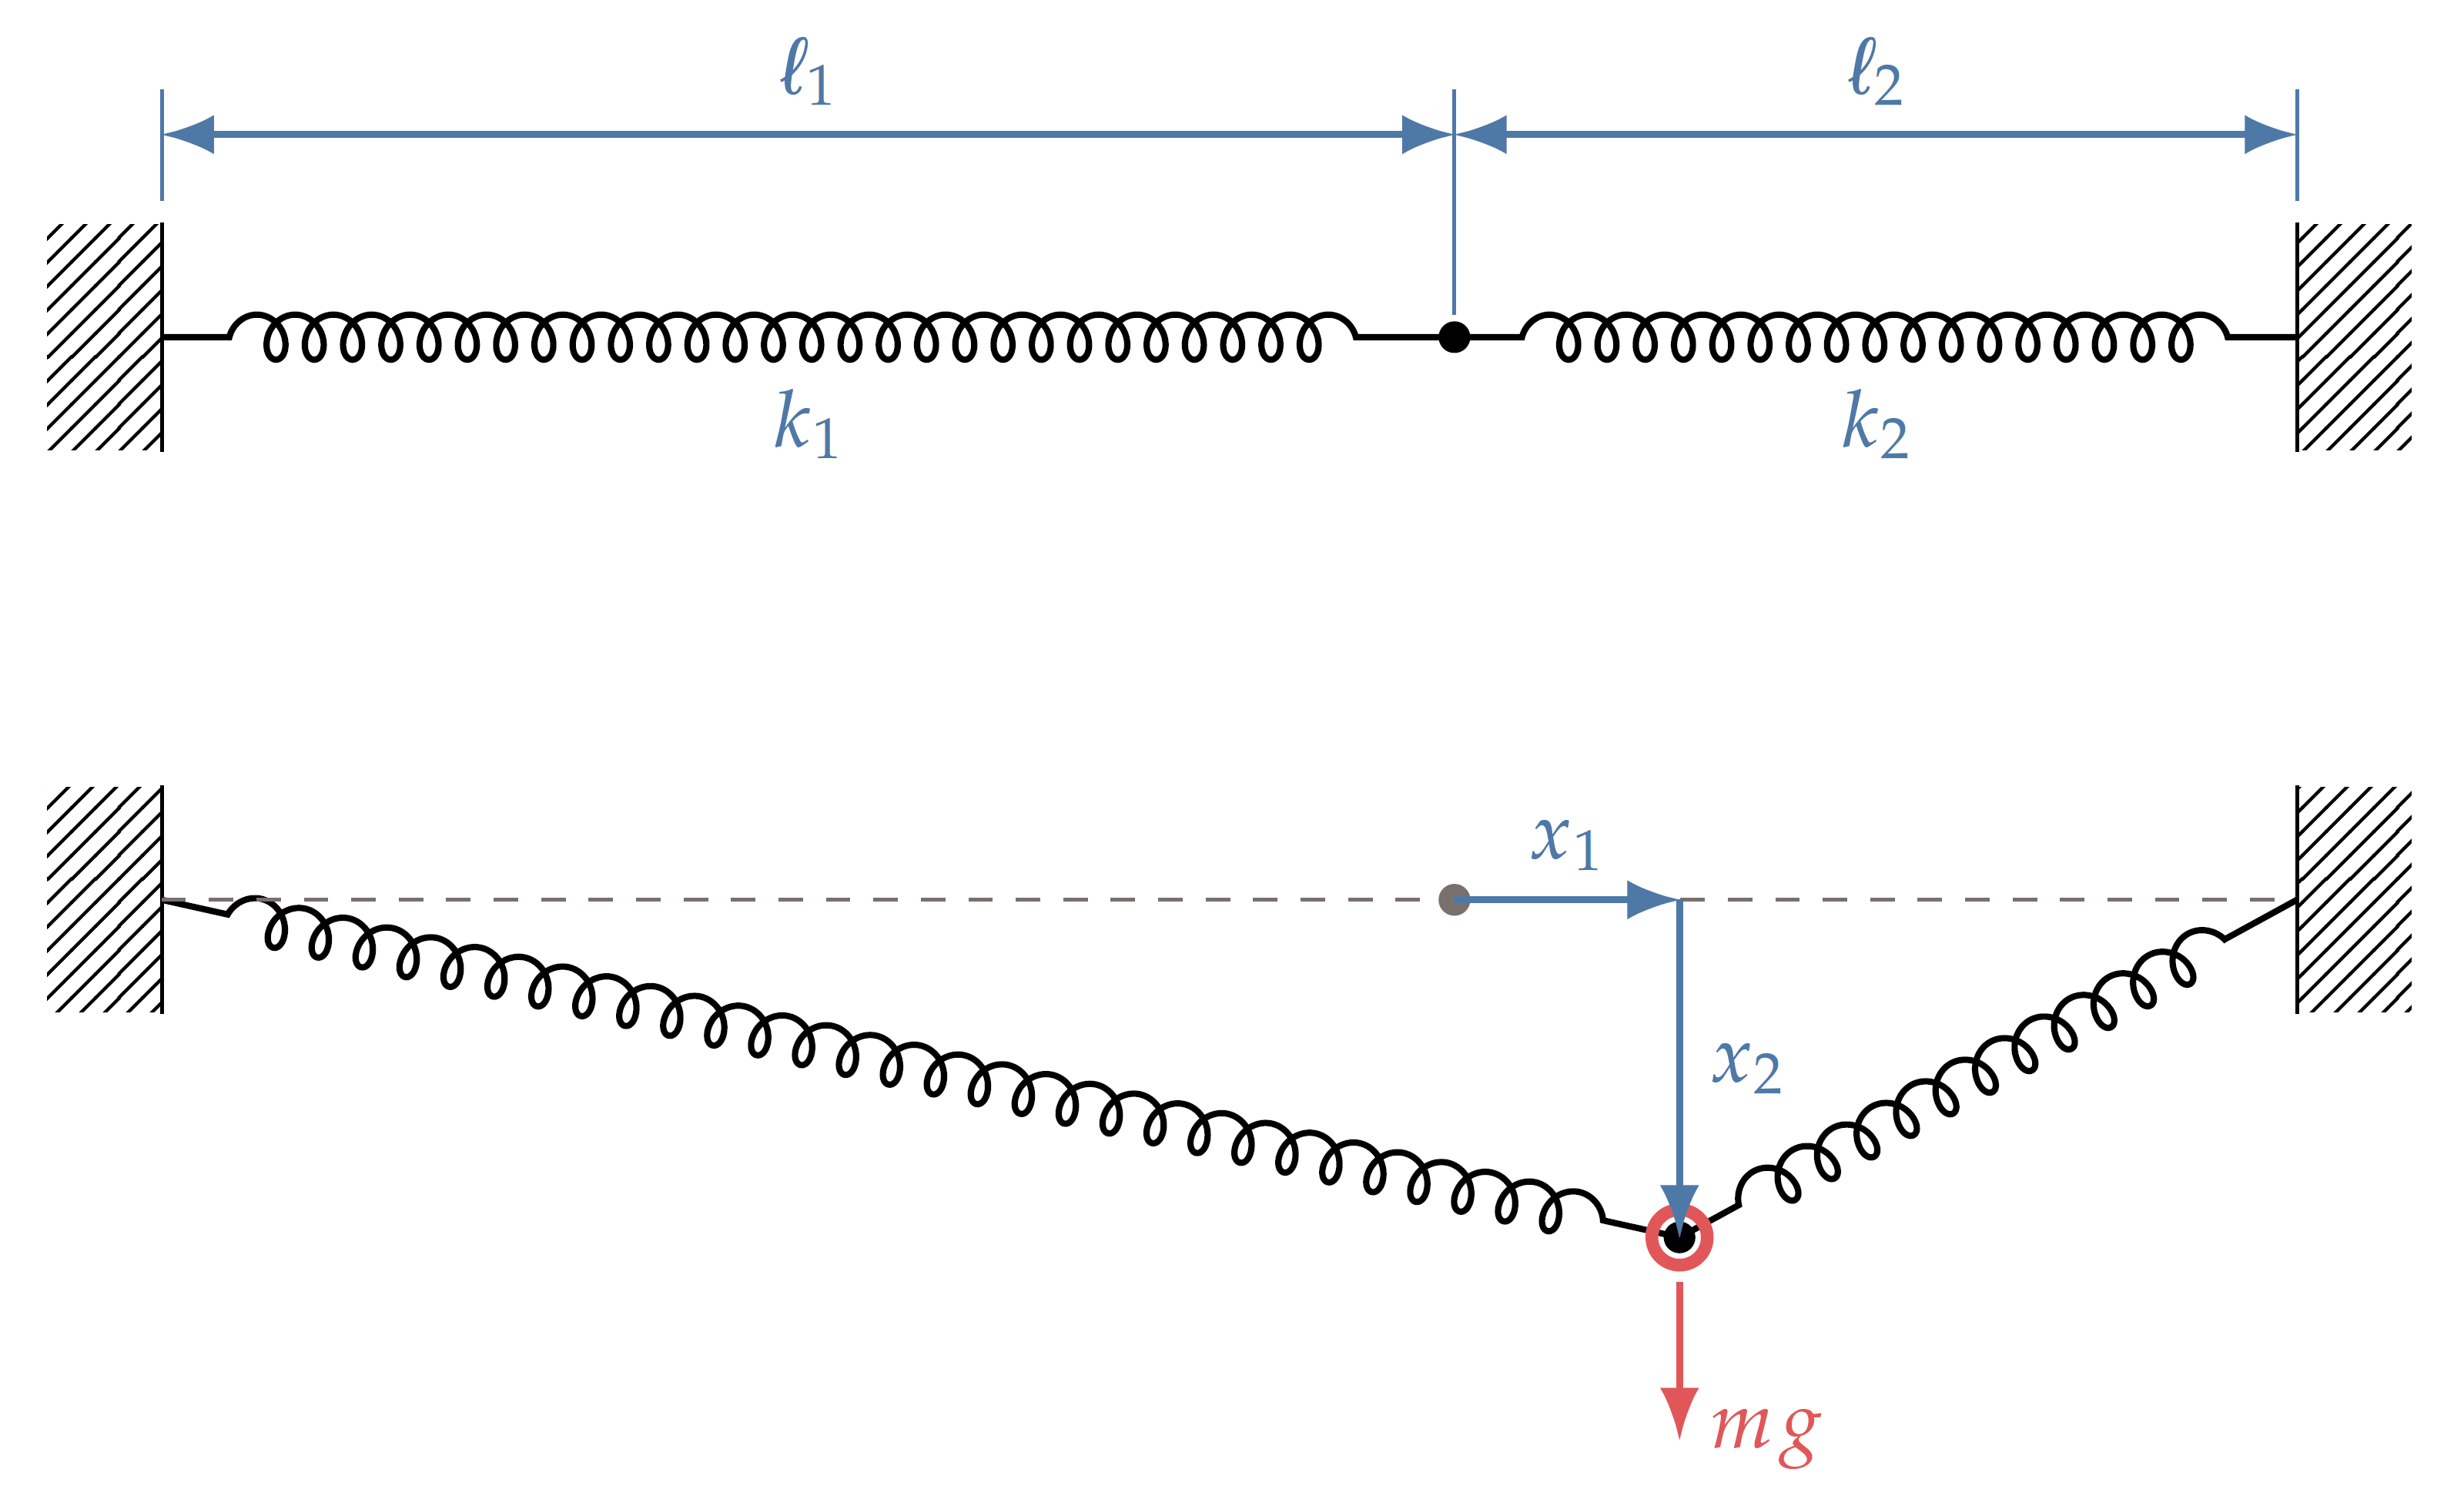

In [10]:
display(Image('./pix/Two-spring_system.png', width=im_width))

In [51]:
# definition of objective function and constraints
@counted
def springs(x):
    '''A mass supported by two springs'''
    k1, l1, k2, l2 = 1, 12, 9, 7
    mg = 7
    Energy = 0.5*k1*(((l1+x[0])**2 + x[1]**2)**0.5 - l1)**2 \
           + 0.5*k2*(((l2-x[0])**2 + x[1]**2)**0.5 - l2)**2 \
           - mg*x[1]
    return Energy
springs.__name__ = 'springs'

In [69]:
def set_constants(obj_fun):
    '''Set bounds and optimum point'''
    
    if obj_fun == SQF:
        X_LIM = [-10., 10.]
        F_LIM = [0, obj_fun(np.array([X_LIM[0], X_LIM[1]]))]
        X_OPT = [0., 0.]
    
    elif obj_fun == rosen:
        X_LIM = [-1.2, 1.2]
        F_LIM = [0, 680]
        X_OPT = [1., 1.]

    elif obj_fun == bean:
        X_LIM = [-2, 2]
        F_LIM = [0, 50]
        X_OPT = [1.21314, 0.82414]

    elif obj_fun == jones:
        X_LIM = [-1.5, 3.5]
        F_LIM = [-15, 40]
        X_OPT = [2.6732, -0.6759]
    
    elif obj_fun == springs:
        X_LIM = [-3, 10]
        F_LIM = [-40, 225]
        X_OPT = [2.664, 6.393]

    X_LIM = np.array(X_LIM)
    F_LIM = np.array(F_LIM)
    X_OPT = np.array(X_OPT)
    
    return X_LIM, F_LIM, X_OPT

---

## Безуслованая оптимизация

### Постановка задачи

Выбор задачи и установка констант

In [70]:
obj_funs = {'SQF':SQF, 'rosen':rosen, 'bean':bean, 'jones':jones, 'springs':springs} # choose a function

obj_fun = obj_funs['springs']
X_LIM, F_LIM, X_OPT = set_constants(obj_fun)
F_OPT = obj_fun(X_OPT)

print(f'obj_fun = {obj_fun.__name__}')
print(f'X_OPT = {X_OPT}, F_OPT = {F_OPT:.3f}')

obj_fun = springs
X_OPT = [2.664 6.393], F_OPT = -34.400


Отрисовка графиков выбранной целевой функции

In [71]:
# functions for visualization
def fun_2d(X1, X2, fun):
    array_2d = np.zeros((len(X1), len(X2)))
    for i, x2 in enumerate(X2):
        for j, x1 in enumerate(X1):
            array_2d[i, j] = fun(np.array([x1, x2]))
    return array_2d

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


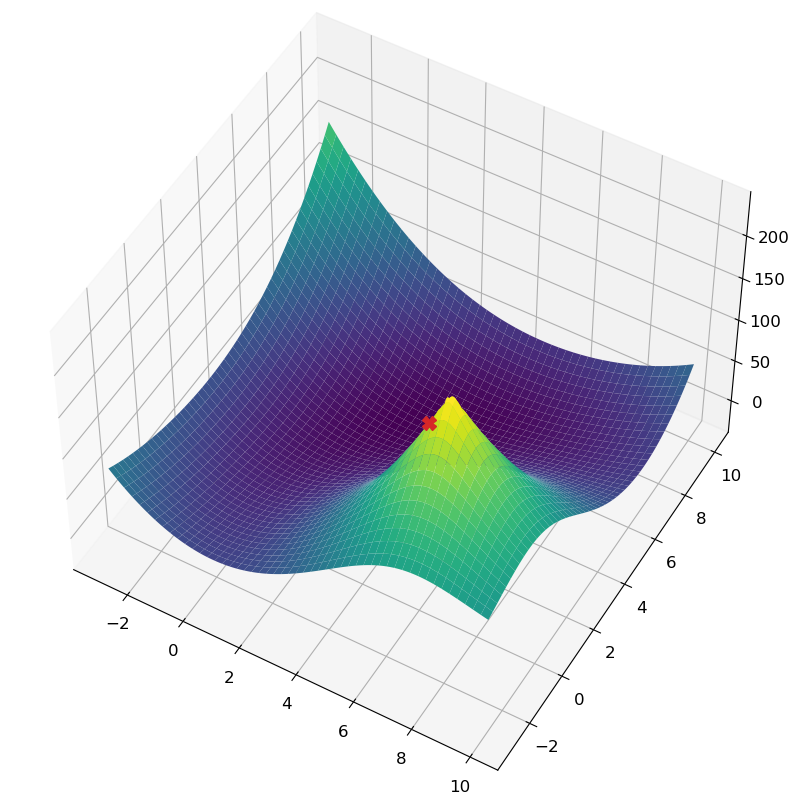

In [72]:
X = np.arange(*X_LIM, 0.01)
Y = np.arange(*X_LIM, 0.01)
X, Y = np.meshgrid(X, Y)
Z = obj_fun(np.array([X,Y]))

# 3d axis
fig = plt.figure(figsize=[15, 10])
ax = fig.gca(projection='3d')

# set angle
ax.view_init(50, -60)

# surface
ax.plot_surface(X, Y, Z, cmap=mpl.cm.viridis)
ax.plot(*X_OPT, F_OPT, 'X', c=cm(3), ms=10, zorder=3)
plt.show()

In [73]:
from mpl_toolkits.mplot3d import Axes3D
X1 = X2 = np.linspace(*X_LIM, 401)
A = fun_2d(X1, X2, obj_fun)

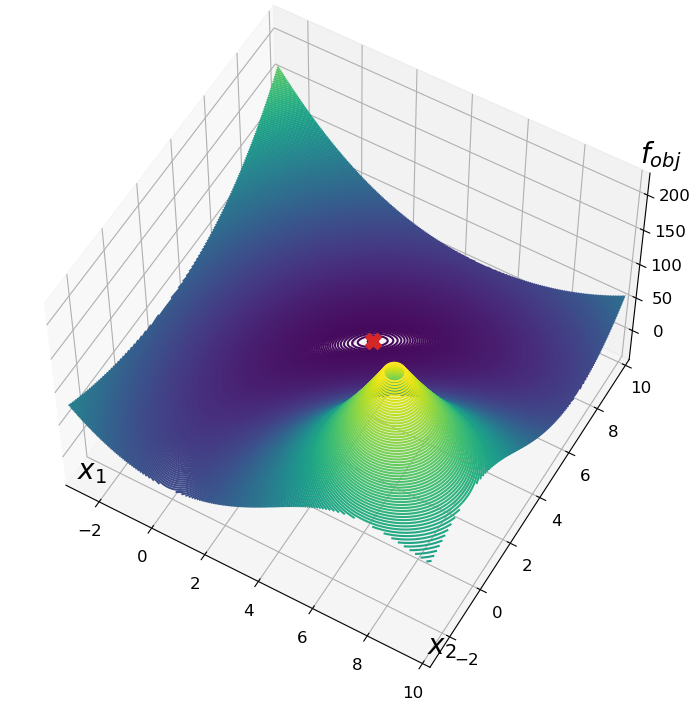

In [74]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

z_lines = np.linspace(0, F_LIM[1]**0.5, 200)**2
if (F_LIM[0] < 0):
    z_lines_1 = np.linspace(F_LIM[0], 0, 200)
    z_lines = np.concatenate((z_lines_1[:-1], z_lines))
        
ax.contour3D(X1, X2, A, z_lines)
ax.plot(*X_OPT, F_OPT, 'X', c=cm(3), ms=12, zorder=100)

ax.set_xlim(*X_LIM)
ax.set_ylim(*X_LIM)
ax.set_zlim(*F_LIM)
ax.text(X_LIM[0], X_LIM[0], F_LIM[0],     '$x_1$', fontsize=20)
ax.text(X_LIM[1], X_LIM[0], F_LIM[0],     '$x_2$', fontsize=20)
ax.text(X_LIM[1], X_LIM[1], 1.1*F_LIM[1], '$f_{obj}$', fontsize=20)
# ax.set_zticks([0,200,400,600])

ax.view_init(55)

plt.tight_layout()
plt.show()
# plt.savefig('rosen_3D.png',dpi=200,bbox_inches='tight')

In [75]:
def fun_contours(fun, points=[], constr=None, trajectory=[], figname=''):
    '''Draw function 2D contours'''
    plt.figure(figsize=(7, 7))
    X1 = X2 = np.linspace(*X_LIM, 401)

    # function contours
    z_lines = np.linspace(0, F_LIM[1]**0.5, 20)**2
    if (F_LIM[0] < 0):
        z_lines_1 = np.linspace(F_LIM[0], 0, 20)
        z_lines = np.concatenate((z_lines_1[:-1], z_lines))
    
    contours = plt.contour(X1, X2, fun_2d(X1,X2,fun), z_lines,
                           linewidths=1., colors='k', alpha=0.9)
    plt.clabel(contours, fontsize=8, fmt='%.0f')

    # points
    for point in points:
        plt.plot(*point, 'x', c=cm(3), mew=2., ms=15)
    
    # trajectory
    if (len(trajectory) != 0):
        plt.plot(*trajectory[:,0],   'o', c=cm(0), ms=8)
        plt.plot(*trajectory,       '-o', c=cm(0), ms=3.5)
        plt.plot(*trajectory[:,-1],  '+', c=cm(0), mew=2., ms=15)
    
    # constraint
    if constr:
        plt.contour(X1,X2,fun_2d(X1,X2,constr),0,linewidths=1.,colors=cm(1))

    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation='horizontal', horizontalalignment='center')
    plt.xlim(*X_LIM)
    plt.ylim(*X_LIM)
    plt.tight_layout()
    plt.show()
    if (figname):
        plt.savefig(figname, dpi=200, bbox_inches='tight')

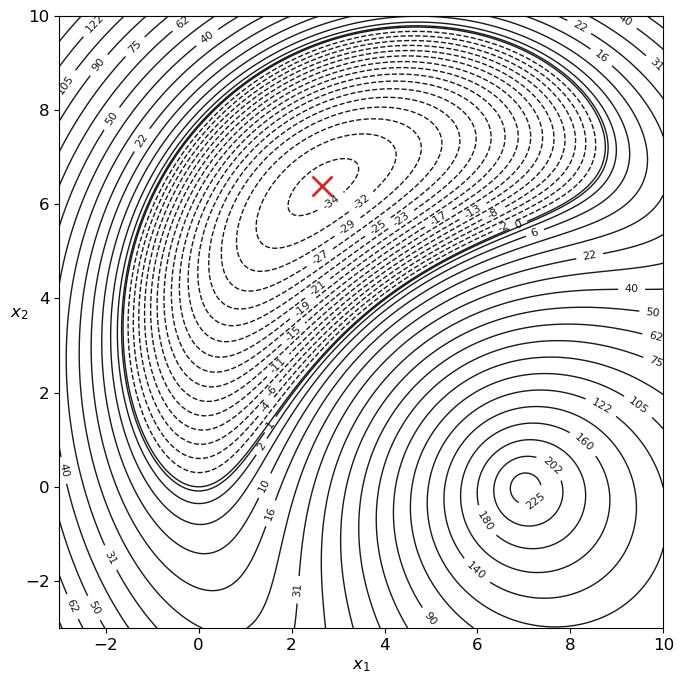

In [76]:
# figname = '1-0.task.png'
fun_contours(obj_fun, points=[X_OPT])

Установка опций

In [77]:
np.random.seed(42)
# X0 = (X_LIM[1]-X_LIM[0])*np.random.rand(*X_OPT.shape) + X_LIM[0]
X0 = np.array([-1, -1])
TOL = 1e-3
opt_eps = 1e-3

print(f'X0 = {X0}, f_obj = {obj_fun(X0):.3f}')
print(f'TOL = {TOL}, opt_eps = {opt_eps}')

X0 = [-1 -1], f_obj = 12.533
TOL = 0.001, opt_eps = 0.001


### Метод сопряжённых градиентов ###

In [20]:
# sp.optimize.show_options(solver='minimize', method='CG')

In [78]:
# CG
x0 = X0
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='CG', tol=TOL,
               options={'disp':True, 'eps':opt_eps, 'return_all':True})
Xk  = np.array(res.allvecs).T
Xk2 = np.array(obj_fun.Xk).T

print(f'\nobjective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OPT:.3}\n')

         Current function value: -34.399575
         Iterations: 8
         Function evaluations: 201
         Gradient evaluations: 63

objective calls = 201
x = [2.66366547 6.39342425], f_obj_error = -1.52e-06



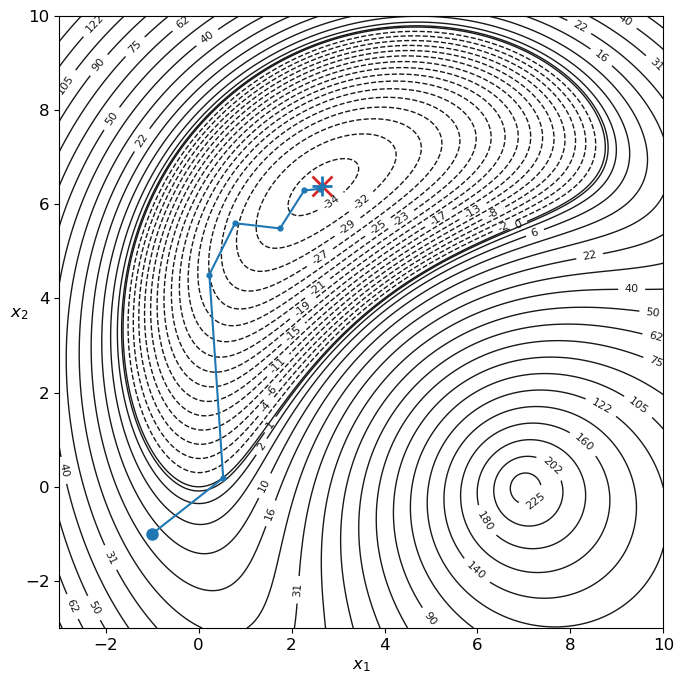

In [79]:
# figname = '1-1.CG.png'
fun_contours(obj_fun, points=[X_OPT], trajectory=Xk)

### Метод Бройдена — Флетчера — Гольдфарба — Шанно (BFGS)

In [23]:
# sp.optimize.show_options(solver='minimize', method='BFGS')

In [24]:
# BFGS
x0 = X0
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='BFGS', tol=TOL,
               options={'disp':True, 'eps':opt_eps, 'return_all':True})
Xk  = np.array(res.allvecs).T
Xk2 = np.array(obj_fun.Xk).T

print(f'\nobjective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OPT:.3}\n')

         Current function value: -4.473340
         Iterations: 13
         Function evaluations: 204
         Gradient evaluations: 64

objective calls = 204
x = [ 1.98308891 -1.25265865], f_obj_error = 9.06



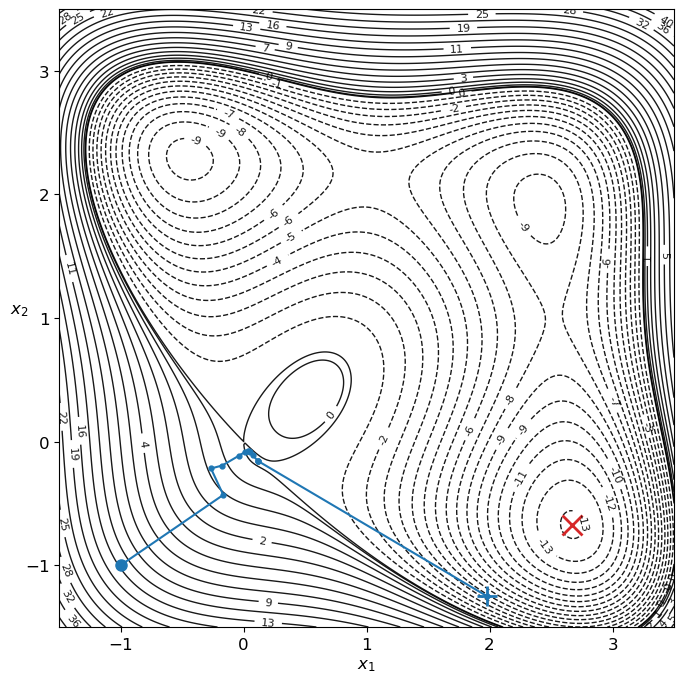

In [25]:
# figname = '1-2.BFGS.png'
fun_contours(obj_fun, points=[X_OPT], trajectory=Xk)

### Метод Нелдера — Мида (симплекс)

In [26]:
# sp.optimize.show_options(solver='minimize', method='Nelder-Mead')

In [27]:
# Nelder-Mead
x0 = X0
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='Nelder-Mead', tol=TOL,
               options={'disp':True, 'return_all':True})
Xk  = np.array(res.allvecs).T
Xk2 = np.array(obj_fun.Xk).T

print(f'objective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OPT:.3}\n')

Optimization terminated successfully.
         Current function value: -13.532034
         Iterations: 34
         Function evaluations: 67
objective calls = 67
x = [ 2.67333404 -0.67563826], f_obj_error = 7.97e-07



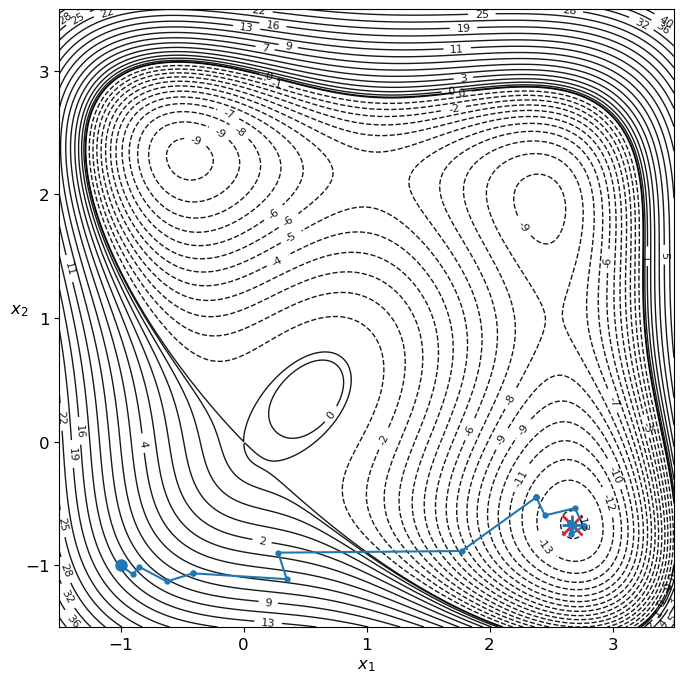

In [28]:
# figname = '1-2.Nelder-Mead.png'
fun_contours(obj_fun, points=[X_OPT], trajectory=Xk)

---

## Услованая оптимизация ##

### Постановка задачи ###

Продолжим работать с функцией Розенброка:

$$  f(x_1, x_2) = (1-x_1)^2 + 100(x_2 - x_1^2)^2. $$

Но теперь добавим нелинейное ограничение:

$$ c(\mathbf{x}) = \sum\limits_{i=1}^{N} x_i^2. $$

Решение будем искать внутри кольца:
$$
    \min_{x_i} f(x), \\
    0.8 \le c(x) \le 1. \\
$$

In [29]:
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds

In [30]:
# definition of constraints
# @counted
def ring(x, center, radius, width):
    '''Ring with center [center], radius [radius] and width [width]'''
    
    r = sum((x - center)**2)**0.5
    if (width == 0.):
        return (r - radius)
    else:
        return ( r - (radius-0.5*width) )**2 - (0.5*width)**2

In [31]:
# define objective function
obj_fun = obj_funs['rosen']
X_LIM, F_LIM, X_OPT = set_constants(obj_fun)
F_OPT = obj_fun(X_OPT)

print(f'obj_fun = {obj_fun.__name__}')
print(f'X_OPT = {X_OPT}, F_OPT = {F_OPT:.3f}')

obj_fun = rosen
X_OPT = [1. 1.], F_OPT = 0.000


In [32]:
# define ring
Center = np.array([0, 0])
radius, width = 1., 0.2
# radius, width = 0.5*X_LIM[1], 0.1*X_LIM[1]
constr = lambda x: ring(x, Center, radius, width)
print(f'radius = {radius}, width = {width}')

radius = 1.0, width = 0.2


In [34]:
N_rad = int(1e6)
alpha_rad = np.linspace(0, 2*np.pi, N_rad)
alpha_deg = np.degrees(alpha_rad)
f1 = obj_fun(radius * np.array([np.cos(alpha_rad), np.sin(alpha_rad)]))

idx_min = np.argmin(f1)
alpha_opt = alpha_deg[idx_min]

# alpha_opt = 38.16 # it was found approximately for rosen
X_OPT = radius*np.array([np.cos(np.radians(alpha_opt)), np.sin(np.radians(alpha_opt))])
F_OBJ = obj_fun(X_OPT)
print(f'X_OPT = {X_OPT}, f_obj = {F_OBJ:.3}, c = {constr(X_OPT):.3}\n')

X_OPT = [0.78641611 0.61769709], f_obj = 0.0457, c = -6.94e-18



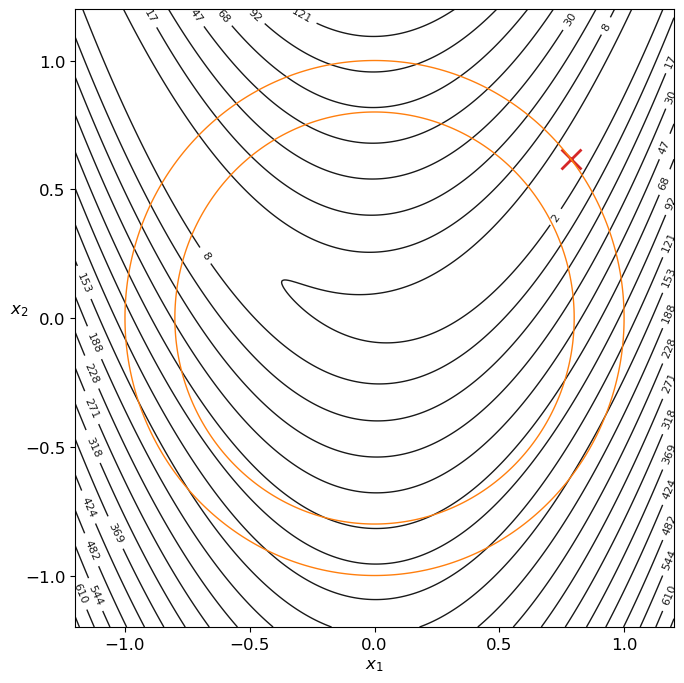

In [35]:
fun_contours(obj_fun, points=[X_OPT], constr=constr)

In [36]:
# it works ONLY for rosen function

r1, r2 = radius-width, radius
# alpha_rad = np.linspace(0, 2*np.pi, 36001)
# alpha_deg = np.degrees(alpha_rad)
f1 = obj_fun(r1 * np.array([np.cos(alpha_rad), np.sin(alpha_rad)]))
f2 = obj_fun(r2 * np.array([np.cos(alpha_rad), np.sin(alpha_rad)]))

In [37]:
eps = 1e3/N_rad

a1 = alpha_deg[np.argmin(f2[alpha_deg<50])]

idx_50 = np.where(abs(alpha_deg-50)<eps)[0][0]
idx_min = idx_50 + np.argmin(f1[np.all([alpha_deg>=50,alpha_deg<200],axis=0)]) + 1
a2 = alpha_deg[idx_min]

idx_200 = np.where(abs(alpha_deg-200)<eps)[0][0]
idx_min = idx_200 + np.argmin(f1[np.all([alpha_deg>=200,alpha_deg<300],axis=0)]) + 1
a3 = alpha_deg[idx_min]

print(a1, a2, a3)
X_OPT_C1 = (radius-width) * np.array([np.cos(np.radians(a2)), np.sin(np.radians(a2))])
X_OPT_C2 = (radius-width) * np.array([np.cos(np.radians(a3)), np.sin(np.radians(a3))])

38.148158148158146 146.07086607086606 271.17387117387113


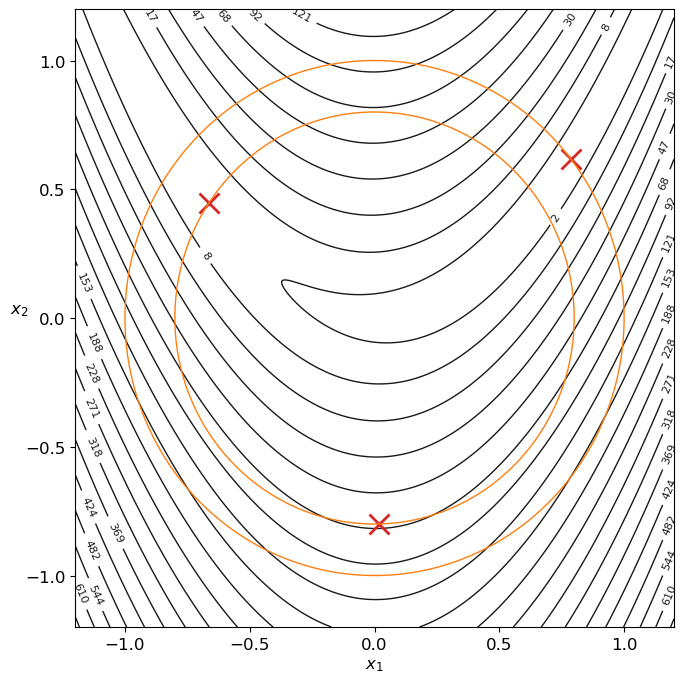

In [38]:
points = [ X_OPT, X_OPT_C1, X_OPT_C2, ]
fun_contours(obj_fun, points=points, constr=constr)

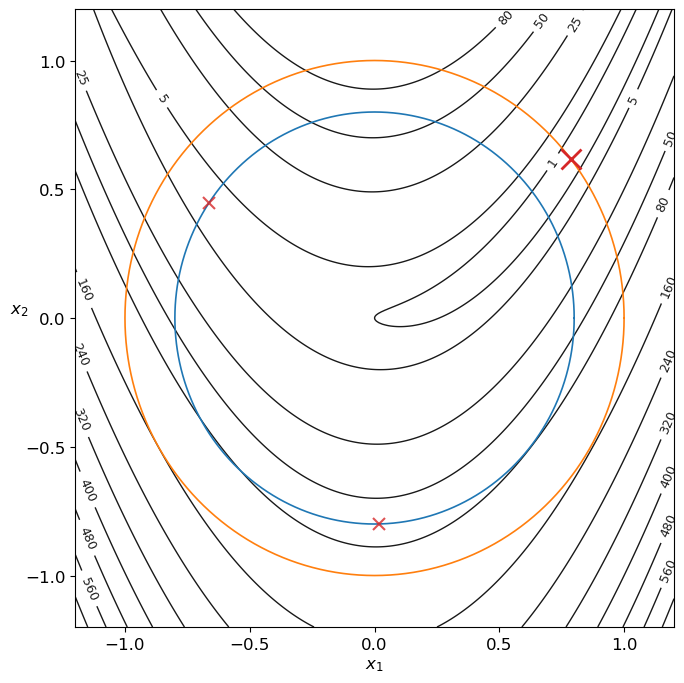

In [39]:
plt.figure(figsize=(7, 7))
X1 = X2 = np.linspace(*X_LIM, 401)

# objective function simple contours
contours = plt.contour(X1,X2,fun_2d(X1,X2,obj_fun),10,linewidths=1.,colors='k',alpha=0.9)
plt.clabel(contours, fontsize=9, fmt='%1.0f')
contours2 = plt.contour(X1,X2,fun_2d(X1,X2,obj_fun),[1,5,25,50],linewidths=1.,colors='k',alpha=0.9)
plt.clabel(contours2, fontsize=9, fmt='%1.0f')

# ring
# c1 = plt.contour(X1,X2,ring_v(X1,X2,Center,radius,width),0,linewidths=1.,colors=cm(1))
alpha = np.linspace(0, 2*np.pi, 1001)
plt.plot(r1*np.cos(alpha), r1*np.sin(alpha), c=cm(0), lw=1.2)
plt.plot(r2*np.cos(alpha), r2*np.sin(alpha), c=cm(1), lw=1.2)

# points
plt.plot(*X_OPT, 'x', c=cm(3), mew=2., ms=15)
plt.plot(*X_OPT_C1, 'x', c=cm(3), mew=1.5, ms=9, alpha=0.8)
plt.plot(*X_OPT_C2, 'x', c=cm(3), mew=1.5, ms=9, alpha=0.8)
    
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$", rotation='horizontal', horizontalalignment='center')
plt.xlim(*X_LIM)
plt.ylim(*X_LIM)
plt.tight_layout()
plt.show()
# plt.savefig('2-0.task_constr-2.png',dpi=200,bbox_inches='tight')

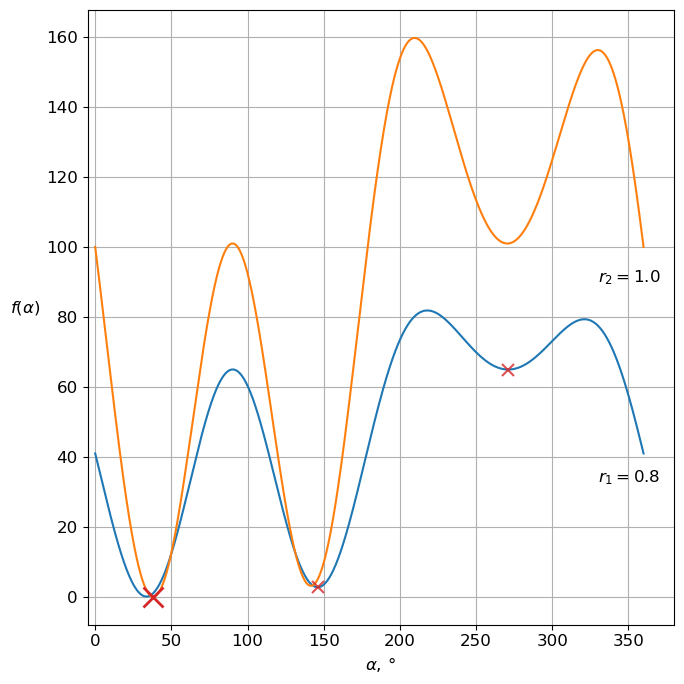

In [40]:
plt.figure(figsize=(7, 7))

# points
plt.plot(alpha_deg, f1, '-', lw=1.5, c=cm(0))
plt.plot(alpha_deg, f2, '-', lw=1.5, c=cm(1))

# text
plt.text(alpha_deg[-1]-30, 0.80*f1[-1], f'$r_1 = {r1}$')
plt.text(alpha_deg[-1]-30, 0.90*f2[-1], f'$r_2 = {r2}$')

# points
plt.plot(a1, obj_fun(X_OPT),  'x', c=cm(3), mew=2., ms=15)
plt.plot(a2, obj_fun(X_OPT_C1), 'x', c=cm(3), mew=1.5, ms=9, alpha=0.8)
plt.plot(a3, obj_fun(X_OPT_C2), 'x', c=cm(3), mew=1.5, ms=9, alpha=0.8)

plt.xlabel(r"$\alpha,\,\degree$")
plt.ylabel(r"$f(\alpha)$", rotation='horizontal', ha='right')
plt.grid()
plt.xlim(-5, 380)
# plt.ylim(*XLIM)
plt.tight_layout()
plt.show()
# plt.savefig('2-0.task_constr-3.png',dpi=200,bbox_inches='tight')

Установка опций

In [41]:
np.random.seed(42)
# X0 = (X_LIM[1]-X_LIM[0])*np.random.rand(*X_OPT.shape) + X_LIM[0]
X0 = np.array([-1, -1])
TOL = 1e-3
opt_eps = 1e-3

print(f'X0 = {X0}, f_obj = {obj_fun(X0):.3f}')
print(f'TOL = {TOL}, opt_eps = {opt_eps}')

X0 = [-1 -1], f_obj = 404.000
TOL = 0.001, opt_eps = 0.001


In [42]:
# define bounds and constraints
bnds = Bounds(X_LIM[0], X_LIM[1])
nonl_constr = NonlinearConstraint(constr, -1e6, 0.)

### Метод COBYLA ###

In [42]:
# sp.optimize.show_options(solver='minimize', method='COBYLA')

In [43]:
# COBYLA-1 first initial point
x0 = X0
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='COBYLA', tol=TOL,
               constraints=[nonl_constr], options={'disp':True})
# Xk  = np.array(res.allvecs).T
Xk2 = np.array(obj_fun.Xk).T

print(res)
print(f'\nobjective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OBJ:.3}, constr = {constr(res.x)}\n')

     fun: -6.700989809119076
   maxcv: 2.9427940764423233e-07
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([ 1.70992815, -0.37235558])

objective calls = 36
x = [ 1.70992815 -0.37235558], f_obj_error = 0.577, constr = 2.9427940764423233e-07



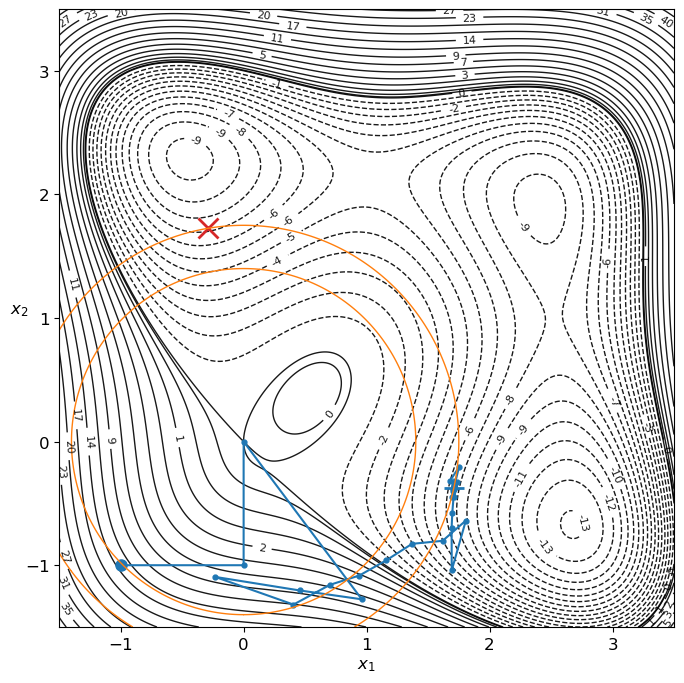

In [44]:
# points = [ X_OPT, X_OPT_C1, X_OPT_C2, ]
points = [ X_OPT, ]
fun_contours(obj_fun, points=points, constr=constr, trajectory=Xk2)

In [45]:
# COBYLA-2: second initial point
X0_2 = np.array([-1., 1.])
x0 = X0_2
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='COBYLA', tol=TOL,
               constraints=[nonl_constr], options={'disp':True})
Xk2 = np.array(obj_fun.Xk).T

print(res)
print(f'\nobjective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OBJ:.3}, constr = {constr(res.x)}\n')

     fun: -7.277710017392628
   maxcv: 2.0109782298063927e-07
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([-0.29100486,  1.72563559])

objective calls = 36
x = [-0.29100486  1.72563559], f_obj_error = 9.13e-06, constr = 2.0109782298063927e-07



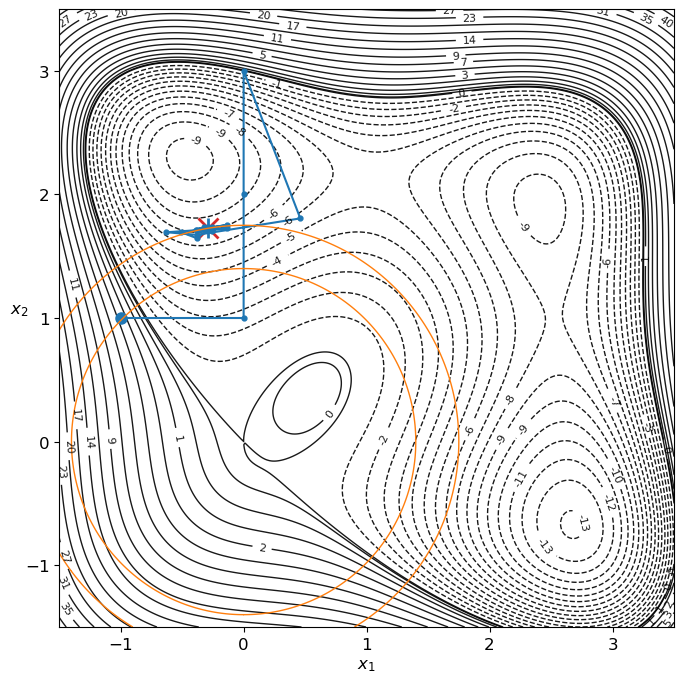

In [46]:
fun_contours(obj_fun, points=points, constr=constr, trajectory=Xk2)

In [47]:
# COBYLA-3: third initial point
X0_3 = np.array([-0.5, -0.5])
x0 = X0_3
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='COBYLA', tol=TOL,
               constraints=[nonl_constr], options={'disp':True})
Xk2 = np.array(obj_fun.Xk).T

print(res)
print(f'\nobjective calls = {obj_fun.calls}')
print(f'x = {res.x}, f_obj_error = {res.fun-F_OBJ:.3}, constr = {constr(res.x)}\n')

     fun: -6.7009846381192535
   maxcv: 2.978929206608194e-07
 message: 'Optimization terminated successfully.'
    nfev: 34
  status: 1
 success: True
       x: array([ 1.70960729, -0.37382601])

objective calls = 34
x = [ 1.70960729 -0.37382601], f_obj_error = 0.577, constr = 2.978929206608194e-07



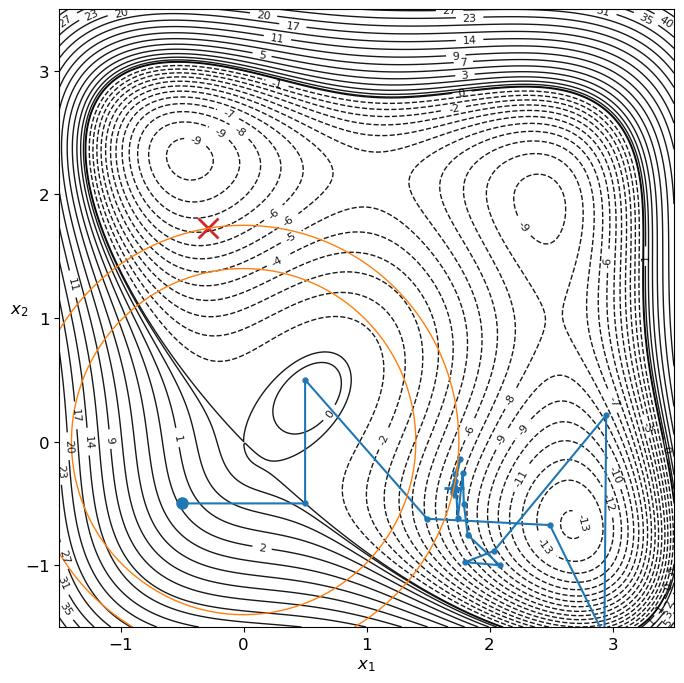

In [48]:
fun_contours(obj_fun, points=points, constr=constr, trajectory=Xk2)

### Метод SLSQP ###

In [49]:
# sp.optimize.show_options(solver='minimize', method='SLSQP')

In [50]:
# SLSQP
x0 = X0
Xk = [x0]
obj_fun.calls = 0
obj_fun.Xk = []
res = minimize(obj_fun, x0, method='SLSQP', tol=TOL,
               bounds=bnds, constraints=[nonl_constr], 
               callback=store, options={'disp':True, 'iprint':2})
Xk = np.array(Xk).T
Xk2 = np.array(obj_fun.Xk).T

print(f'objective calls = {obj_fun.calls}')
print(f'x = {res.x}, eps_obj = {res.fun-F_OBJ:.3}, constr = {constr(res.x)}\n')

  NIT    FC           OBJFUN            GNORM
    1     4     1.757572E+01     2.662705E+01
    2     8     1.227749E+01     2.565128E+01
    3    11     1.178470E+01     2.597061E+01
    4    14     1.179700E+01     2.502991E+01
    5    16     1.179700E+01     2.504196E+01
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.79700381020752
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
objective calls = 16
x = [-0.70781902 -1.20788764], eps_obj = 19.1, constr = -4.000214281693615e-08



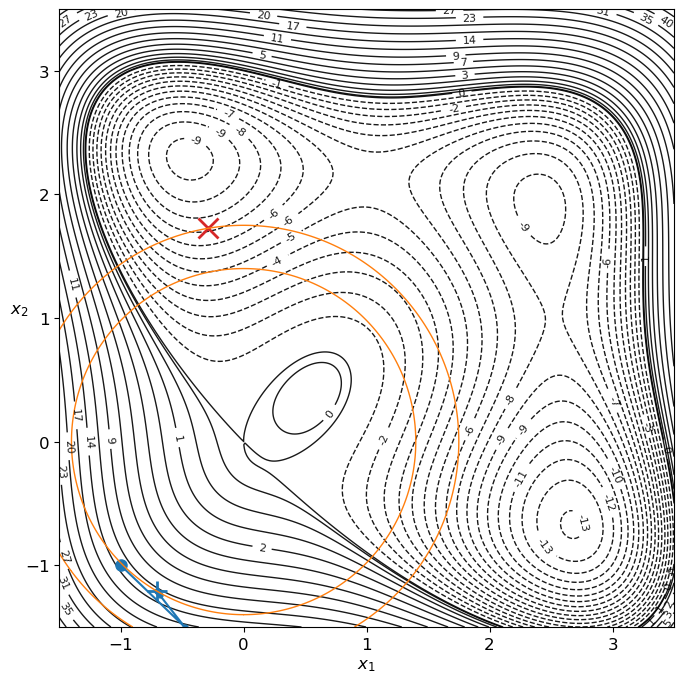

In [51]:
fun_contours(obj_fun, points=points, constr=constr, trajectory=Xk)

In [52]:
print(X_OPT, obj_fun(X_OPT))
print(res.x, obj_fun(res.x))

[-0.29225305  1.72542405] -7.277719148544097
[-0.70781902 -1.20788764] 11.79700381020752
